# 05 — Probabilistic forecasts (24-hour ahead)

This notebook repeats the probabilistic forecasting workflow from Notebook 04, but for a 24-hour-ahead
load forecasting horizon. Longer horizons generally have:

- larger point errors
- wider prediction intervals
- harder calibration (more regime shift / nonstationarity)

We compare:
- Quantile regression: direct conditional quantiles (80% band via q0.1–q0.9)
- Conformal prediction: residual-based 90% intervals around a point forecast

Metrics:
- Coverage and width (sharpness)
- MAE/RMSE (point accuracy)
- Quantile calibration and pinball loss
- Stress tests: extremes, peak week, hour-of-day diagnostics


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src.data import load_opsd_germany
from src.features import make_features
from src.models import train_point_model, train_quantile_models, predict_quantiles
from src.conformal import compute_absolute_residuals, conformal_interval
from src.evaluation import (
    regression_metrics,
    interval_coverage,
    interval_width,
    quantile_calibration,
    plot_quantile_calibration,
    pinball_loss,
)

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

In [6]:
raw = load_opsd_germany(str(PROJECT_ROOT / "data" / "time_series_60min_singleindex.csv"))
HORIZON = 24  # 24-hour ahead target
X, y = make_features(raw, horizon=HORIZON, target_col="load")

# 60/20/20 split by time index
n = len(X)
cutoff_train = X.index[int(0.6 * n)]
cutoff_cal = X.index[int(0.8 * n)]

X_train = X[X.index < cutoff_train]
y_train = y[y.index < cutoff_train]

X_cal = X[(X.index >= cutoff_train) & (X.index < cutoff_cal)]
y_cal = y[(y.index >= cutoff_train) & (y.index < cutoff_cal)]

X_test = X[X.index >= cutoff_cal]
y_test = y[y.index >= cutoff_cal]

X_train.shape, X_cal.shape, X_test.shape

((29944, 28), (9981, 28), (9982, 28))

## Method 1 — Quantile regression (80% interval)

In [7]:
quantiles = [0.1, 0.5, 0.9]
q_models = train_quantile_models(X_train, y_train, quantiles=quantiles)

q_preds_test = predict_quantiles(q_models, X_test)
q_preds_test.head()

lower_q = q_preds_test["q_0.1"].values
median_q = q_preds_test["q_0.5"].values
upper_q = q_preds_test["q_0.9"].values

coverage_q = interval_coverage(y_test, lower_q, upper_q)
width_q = interval_width(lower_q, upper_q)
point_metrics_q = regression_metrics(y_test, median_q)

coverage_q, width_q, point_metrics_q

(0.7762973352033661,
 6366.062142273095,
 {'MAE': 1677.298240803998, 'RMSE': 2591.777097025758})

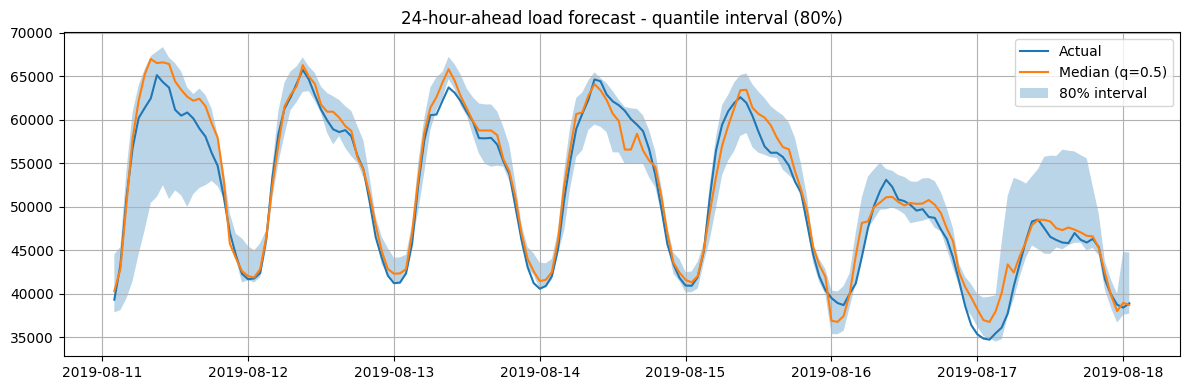

In [8]:
sample = slice(0, 7 * 24)
time = y_test.index[sample]

plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, median_q[sample], label="Median (q=0.5)")
plt.fill_between(time, lower_q[sample], upper_q[sample], alpha=0.3, label="80% interval")

plt.title(f"{HORIZON}-hour-ahead load forecast - quantile interval (80%)")
plt.legend()
plt.tight_layout()
plt.show()


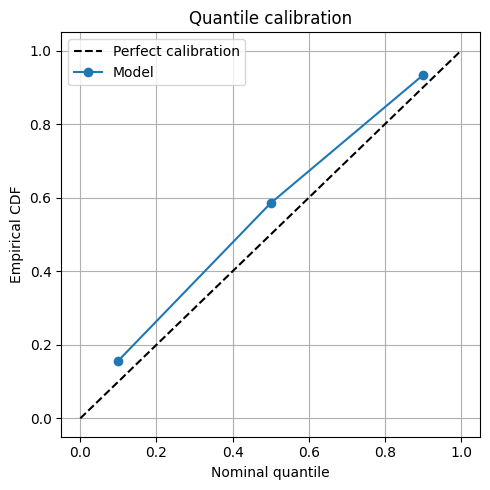

In [9]:
calib_df = quantile_calibration(
    y_true=y_test.values,
    q_pred_dict={
        0.1: q_preds_test["q_0.1"].values,
        0.5: q_preds_test["q_0.5"].values,
        0.9: q_preds_test["q_0.9"].values,
    },
)

calib_df

plot_quantile_calibration(calib_df)

## Method 2 — Conformal prediction intervals (90% target)

In [10]:
point_model = train_point_model(X_train, y_train)

residuals = compute_absolute_residuals(point_model, X_cal, y_cal)
np.quantile(residuals, [0.5, 0.8, 0.9, 0.95])

alpha = 0.1  # target 90% coverage

lower_conf, upper_conf = conformal_interval(
    model=point_model, X=X_test, residuals=residuals, alpha=alpha
)
y_pred_point_test = point_model.predict(X_test)

coverage_conf = interval_coverage(y_test, lower_conf, upper_conf)
width_conf = interval_width(lower_conf, upper_conf)
point_metrics_conf = regression_metrics(y_test, y_pred_point_test)

coverage_conf, width_conf, point_metrics_conf


(0.8958124624323783,
 7312.533578607093,
 {'MAE': 1773.5918011818737, 'RMSE': 2578.866372147258})

At 24h, absolute errors and widths increase; conformal typically maintains target coverage better than direct quantiles.
Conformal tends to be more conservative (often wider) but aims for reliable coverage
Quantile intervals can be sharper but may under-cover in difficult regions (turning points, extremes)

In [11]:
results = pd.DataFrame({
    "method": ["quantile_80", "conformal_90"],
    "coverage": [coverage_q, coverage_conf],
    "avg_width": [width_q, width_conf],
    "MAE": [point_metrics_q["MAE"], point_metrics_conf["MAE"]],
    "RMSE": [point_metrics_q["RMSE"], point_metrics_conf["RMSE"]],
})
results


,method,coverage,avg_width,MAE,RMSE
0,quantile_80,0.776297,6366.062142,1677.298241,2591.777097
1,conformal_90,0.895812,7312.533579,1773.591801,2578.866372


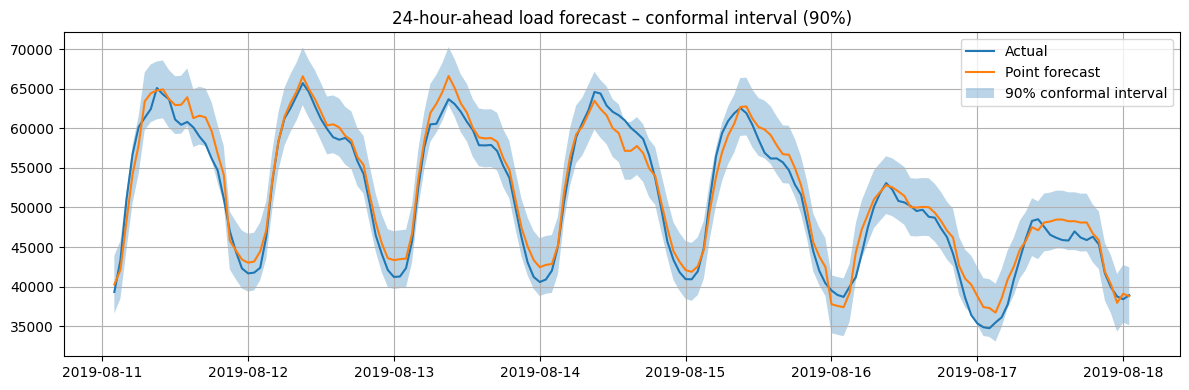

In [12]:
sample = slice(0, 7 * 24)
time = y_test.index[sample]

plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, y_pred_point_test[sample], label="Point forecast")
plt.fill_between(time, lower_conf[sample], upper_conf[sample], alpha=0.3, label="90% conformal interval")

plt.title(f"{HORIZON}-hour-ahead load forecast – conformal interval (90%)")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# pinball loss 
pin_q10 = pinball_loss(y_test.values, q_preds_test["q_0.1"].values, 0.1)
pin_q50 = pinball_loss(y_test.values, q_preds_test["q_0.5"].values, 0.5)
pin_q90 = pinball_loss(y_test.values, q_preds_test["q_0.9"].values, 0.9)

pin_df = pd.DataFrame({
    "quantile": [0.1, 0.5, 0.9],
    "pinball_loss": [pin_q10, pin_q50, pin_q90],
})
pin_df["avg_pinball_3q"] = pin_df["pinball_loss"].mean()
pin_df


,quantile,pinball_loss,avg_pinball_3q
0,0.1,522.608567,585.013088
1,0.5,838.649120,585.013088
2,0.9,393.781577,585.013088


## Stress test 1: extremes (top 5%)

In [14]:
X_percent = 0.05  # top 5%
thr = np.quantile(y_test.values, 1 - X_percent)
mask = (y_test.values >= thr)

ext_cov_q = interval_coverage(y_test.values[mask], lower_q[mask], upper_q[mask])
ext_width_q = interval_width(lower_q[mask], upper_q[mask])

ext_cov_conf = interval_coverage(y_test.values[mask], lower_conf[mask], upper_conf[mask])
ext_width_conf = interval_width(lower_conf[mask], upper_conf[mask])

pd.DataFrame({
    "horizon": [f"{HORIZON}h"] * 2,
    "method": ["quantile_80", "conformal_90"],
    "extreme_top_frac": [X_percent] * 2,
    "coverage_on_extremes": [ext_cov_q, ext_cov_conf],
    "avg_width_on_extremes": [ext_width_q, ext_width_conf],
})


,horizon,method,extreme_top_frac,coverage_on_extremes,avg_width_on_extremes
0,24h,quantile_80,0.05,0.788,6569.892573
1,24h,conformal_90,0.05,0.922,7312.533579


## Stress test 2: peak-load week plot

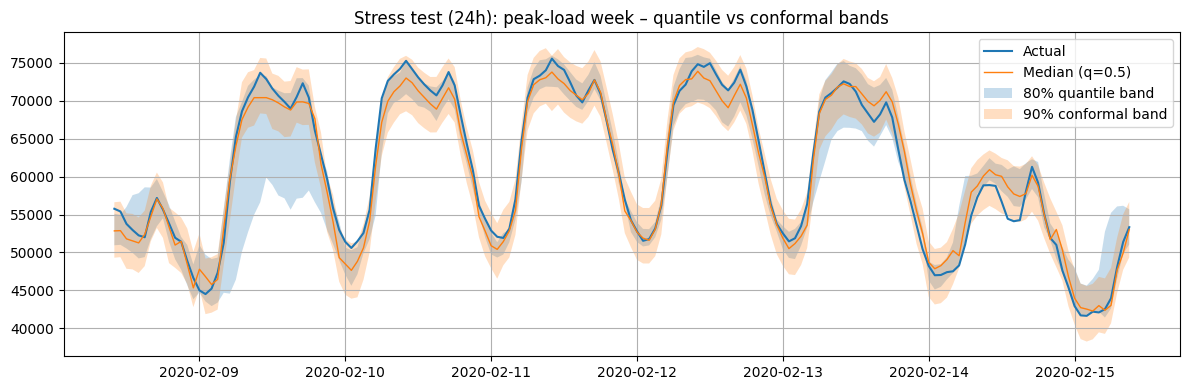

In [15]:
peak_idx = int(np.argmax(y_test.values))
start_idx = max(0, peak_idx - 3 * 24)
end_idx = min(len(y_test), peak_idx + 4 * 24)
sl = slice(start_idx, end_idx)

plt.figure(figsize=(12, 4))
plt.plot(y_test.index[sl], y_test.values[sl], label="Actual", lw=1.5)
plt.plot(y_test.index[sl], median_q[sl], label="Median (q=0.5)", lw=1.0)
plt.fill_between(y_test.index[sl], lower_q[sl], upper_q[sl], alpha=0.25, label="80% quantile band")
plt.fill_between(y_test.index[sl], lower_conf[sl], upper_conf[sl], alpha=0.25, label="90% conformal band")

plt.title(f"Stress test ({HORIZON}h): peak-load week – quantile vs conformal bands")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
hour = y_test.index.hour
median_load = float(np.median(y_test.values))

df = pd.DataFrame({
    "hour": hour,
    "y": y_test.values,
    "q_lower": lower_q,
    "q_upper": upper_q,
    "c_lower": lower_conf,
    "c_upper": upper_conf,
})

records = []
for h, g in df.groupby("hour"):
    records.append({
        "hour": h,
        "cov_q80": interval_coverage(g["y"].values, g["q_lower"].values, g["q_upper"].values),
        "cov_conf90": interval_coverage(g["y"].values, g["c_lower"].values, g["c_upper"].values),
        "width_q80": interval_width(g["q_lower"].values, g["q_upper"].values),
        "width_conf90": interval_width(g["c_lower"].values, g["c_upper"].values),
    })

by_hour = pd.DataFrame(records).sort_values("hour").reset_index(drop=True)
by_hour["width_q80_norm"] = by_hour["width_q80"] / median_load
by_hour["width_conf90_norm"] = by_hour["width_conf90"] / median_load

by_hour


,hour,cov_q80,cov_conf90,width_q80,width_conf90,width_q80_norm,width_conf90_norm
0,0,0.604819,0.910843,4162.129882,7312.533579,0.077893,0.136852
1,1,0.665060,0.930120,4093.816912,7312.533579,0.076614,0.136852
2,2,0.740385,0.920673,4054.442437,7312.533579,0.075878,0.136852
3,3,0.754808,0.915865,4087.940023,7312.533579,0.076504,0.136852
4,4,0.788462,0.814904,7387.119281,7312.533579,0.138248,0.136852
5,5,0.783654,0.766827,10147.698601,7312.533579,0.189911,0.136852
6,6,0.838942,0.841346,10312.326456,7312.533579,0.192992,0.136852
7,7,0.822115,0.887019,8914.326301,7312.533579,0.166829,0.136852
8,8,0.848558,0.920673,7788.339918,7312.533579,0.145756,0.136852
9,9,0.858173,0.923077,7160.887063,7312.533579,0.134014,0.136852


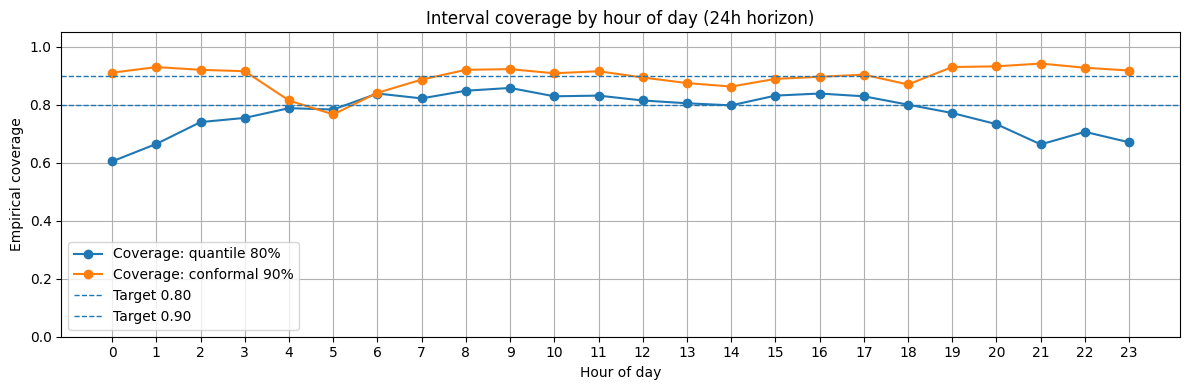

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(by_hour["hour"], by_hour["cov_q80"], marker="o", label="Coverage: quantile 80%")
plt.plot(by_hour["hour"], by_hour["cov_conf90"], marker="o", label="Coverage: conformal 90%")
plt.axhline(0.80, linestyle="--", linewidth=1, label="Target 0.80")
plt.axhline(0.90, linestyle="--", linewidth=1, label="Target 0.90")
plt.xticks(range(0, 24))
plt.ylim(0, 1.05)
plt.title(f"Interval coverage by hour of day ({HORIZON}h horizon)")
plt.xlabel("Hour of day")
plt.ylabel("Empirical coverage")
plt.legend()
plt.tight_layout()
plt.show()


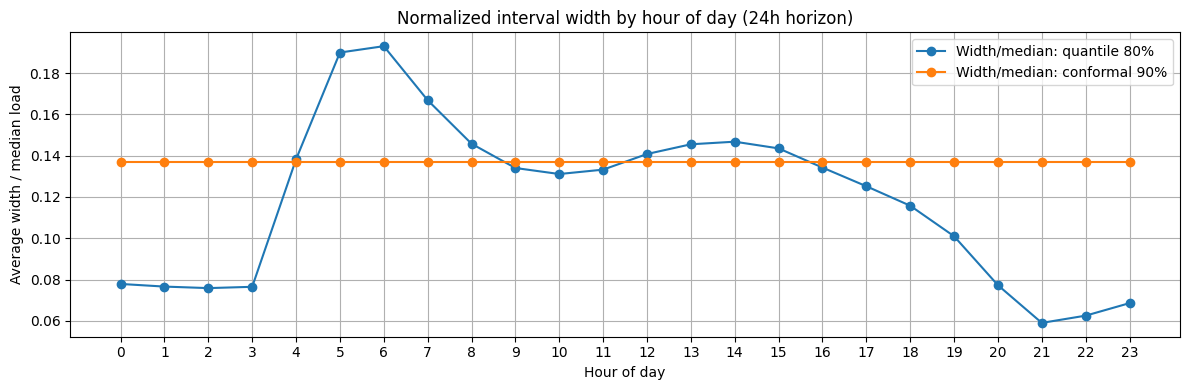

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(by_hour["hour"], by_hour["width_q80_norm"], marker="o", label="Width/median: quantile 80%")
plt.plot(by_hour["hour"], by_hour["width_conf90_norm"], marker="o", label="Width/median: conformal 90%")
plt.xticks(range(0, 24))
plt.title(f"Normalized interval width by hour of day ({HORIZON}h horizon)")
plt.xlabel("Hour of day")
plt.ylabel("Average width / median load")
plt.legend()
plt.tight_layout()
plt.show()


### Takeaways

- At a 24-hour horizon, uncertainty bands should widen and point errors increase compared with short horizons.
- Quantile regression can be sharper but may under-cover around peaks/turning points.
- Conformal prediction often delivers coverage closer to target, sometimes at the cost of wider intervals.

### Limitations

- Basic residual conformal intervals are symmetric and may miss skewed uncertainty.
- Coverage can vary by subgroup (hour-of-day, season, extremes), even if global coverage looks good.
- Any time series regime shift (holidays, weather anomalies, structural changes) can degrade calibration.

### Next improvements

- Use conditional / group conformal (e.g., hour-of-day buckets) to stabilize subgroup coverage
- Model heteroskedasticity (predict residual scale) for tighter conformal bands
- Add monotonic constraints or post-processing to avoid quantile crossing
- Evaluate additional quantiles (e.g., 0.05–0.95) and compare at multiple horizons